# Домашняя работа №3

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import skimage
import os.path

from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K
from keras.callbacks import Callback, History

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import accuracy_score, precision_score
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
SMPL_SIZE = 16

# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.pkl*. Данный файл содержит набор фото. 

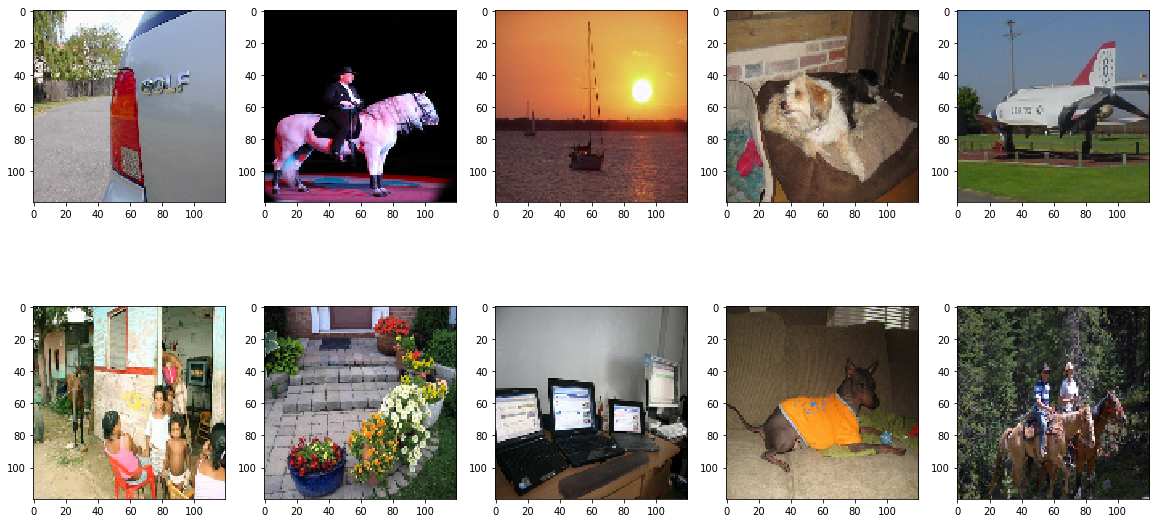

In [3]:
images = np.load(open('data/images.npy', 'br'))
plt.figure(figsize=(20, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [4]:
images.shape

(7000, 120, 120, 3)

In [5]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_seed=123):
    # входные параметры
    # full_images: np.array, исходный датасет
    # num_samples: int, количество патчей, которые функция должна вернуть
    # sample_size: int, длина стороны каждого патча
    # rand_seed: int, число для инициализации np.random.seed, чтобы генерация датасета была воспроизводимой
    
    # выход функции
    # np.array размера [num_samples, sample_size, sample_size, 3]
    
    res_arr = np.empty([num_samples, sample_size, sample_size, 3])
    pic_nums = np.random.randint(full_images.shape[0], size=num_samples)
    for i in range(num_samples):
        offset_x, offset_y = np.random.randint(0, full_images.shape[1]-sample_size),\
                                np.random.randint(0, full_images.shape[1]-sample_size)
        res_arr[i] = full_images[pic_nums[i]][offset_y:offset_y+sample_size, offset_x:offset_x+sample_size]
    return res_arr

In [6]:
samples = get_samples(images, sample_size=SMPL_SIZE, num_samples=10000)

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [7]:
def rgb_scaler(imgs):
    '''На вход подается 2D array'''
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    return scaler.fit_transform(imgs)

In [8]:
def reshape_samples(imgs):
    return imgs.reshape(imgs.shape[0], np.prod(imgs.shape[1:]))

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [9]:
processed_samples = rgb_scaler(reshape_samples(samples))

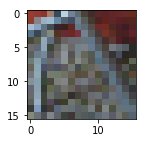

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(processed_samples[0].reshape(SMPL_SIZE, SMPL_SIZE, 3))

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [11]:
def get_best_optimizer(object_size, train_data, valid_data, encoder_layer_shapes=[256, 144, 64],
                       decoder_layer_shapes=[200, 400], epochs=20, **kwargs):
    '''get best optimizer for task with default params'''
    optimizer_scores = {}
    optimizer_list = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
    
    for opt in optimizer_list:
        autoenc = create_autoencoder_model(object_size=object_size, encoder_layer_shapes=encoder_layer_shapes,
                                           decoder_layer_shapes=decoder_layer_shapes, optimizer=opt)
        autoenc.fit(train_data, train_data, epochs=epochs)
        optimizer_scores.update({opt: autoenc.evaluate(valid_data, valid_data)})
        
    best_optimizer = sorted(optimizer_scores.items(), key=lambda x:x[1])[0]
    return best_optimizer[0], best_optimizer[1]

In [12]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400],
                             optimizer='adagrad'):
    # входные параметры:
    # object_size: int, размер входного и выходного слоя автоэнкодера
    # encoder_layer_shapes: list of int, количество нейронов в каждом слое энкодера. 
    #                       последний элемент списка - размер "бутылочного горлышка"
    # decoder_layer_shapes: list of int, количество нейронов в каждом слое декодера
    
    # выход:
    # keras модель
    
    input_img = Input(shape=(object_size,))
    
    encod = Dense(encoder_layer_shapes[0], activation='relu')(input_img)
    for i in range(1, len(encoder_layer_shapes)):
        encod = Dense(encoder_layer_shapes[i], activation='relu')(encod)
        
    if len(decoder_layer_shapes):
        decod = Dense(decoder_layer_shapes[0], activation='relu')(encod)
        for i in range(1, len(decoder_layer_shapes)-1):
            decod = Dense(decoder_layer_shapes[i], activation='relu')(decod)
        decod_out = Dense(object_size, activation='sigmoid')(decod)
    
        encoder = Model(input_img, encod)
        autoencoder = Model(input_img, decod_out)
        autoencoder.compile(loss="mean_squared_error", optimizer=optimizer)
    else:
        encod_out = Dense(object_size, activation='sigmoid')(encod)
        autoencoder = Model(input_img, encod_out)
    
    return autoencoder

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [13]:
train, test = processed_samples[:int(len(processed_samples)*0.9)], processed_samples[int(len(processed_samples)*0.9):]

Обучите модель со стандартными параметрами.

In [14]:
optimizer, score= get_best_optimizer(object_size=SMPL_SIZE*SMPL_SIZE*3, valid_data=test,\
                                     train_data=train)

Epoch 1/20
9000/9000 [==============================] - 3s 314us/step - loss: 0.0511
Epoch 2/20
9000/9000 [==============================] - 2s 192us/step - loss: 0.0509
Epoch 3/20
9000/9000 [==============================] - 2s 202us/step - loss: 0.0507
Epoch 4/20
9000/9000 [==============================] - 2s 220us/step - loss: 0.0506
Epoch 5/20
9000/9000 [==============================] - 2s 209us/step - loss: 0.0506
Epoch 6/20
9000/9000 [==============================] - 2s 197us/step - loss: 0.0505
Epoch 7/20
9000/9000 [==============================] - 2s 197us/step - loss: 0.0505
Epoch 8/20
9000/9000 [==============================] - 2s 201us/step - loss: 0.0504
Epoch 9/20
9000/9000 [==============================] - 2s 191us/step - loss: 0.0504
Epoch 10/20
9000/9000 [==============================] - 2s 189us/step - loss: 0.0504
Epoch 11/20
9000/9000 [==============================] - 2s 191us/step - loss: 0.0503
Epoch 12/20
9000/9000 [==============================] - 2s 193

In [15]:
optimizer, score

('adam', 0.0057559879422187802)

In [16]:
autoenc = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, optimizer=optimizer)

In [17]:
filepath = 'models/autoencoder'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if not os.path.exists(filepath):
    hist = History()
    autoenc.fit(train, train, epochs=20, validation_data=(test, test), callbacks=[hist])
    autoenc.save(filepath)
else:
    autoenc = keras.models.load_model(filepath)

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

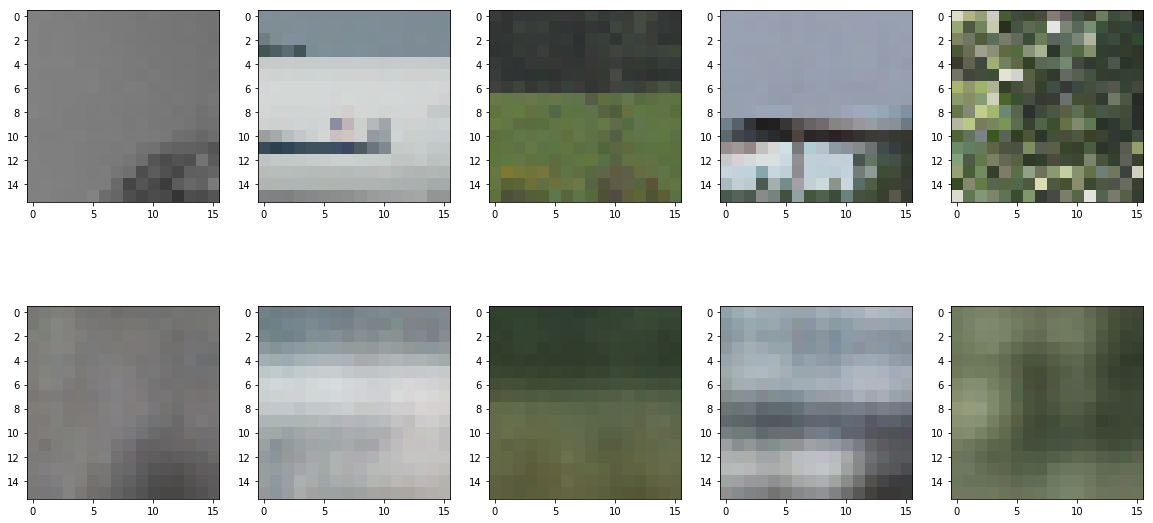

In [18]:
samples = test[np.random.randint(0, len(test), size=5)]
predict = autoenc.predict(samples)
_, ax = plt.subplots(2,5)
for i in range(5):
    ax[0,i].imshow(samples[i].reshape(SMPL_SIZE, SMPL_SIZE, 3))
    ax[1,i].imshow(predict[i].reshape(SMPL_SIZE, SMPL_SIZE, 3))

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

In [21]:
inp = autoenc.input                                           # input placeholder
outputs = [layer.output for layer in autoenc.layers]          # all layer outputs
functors = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

# Testing
#test_tmp = np.random.random(SMPL_SIZE*SMPL_SIZE*3)[np.newaxis,...]
layer_outs = [func([train, 1.]) for func in functors]
print(layer_outs)

[[array([[ 0.58444446,  0.24674837,  0.17066993, ...,  0.33750001,
         0.39081699,  0.44586602],
       [ 0.40843138,  0.34941176,  0.30887255, ...,  0.43799019,
         0.3902941 ,  0.34014705],
       [ 0.53294116,  0.53294116,  0.52666664, ...,  0.51960784,
         0.51960784,  0.51960784],
       ..., 
       [ 0.53627449,  0.54083335,  0.57887256, ...,  0.5360294 ,
         0.56161767,  0.61573529],
       [ 0.39617646,  0.34169933,  0.26540849, ...,  0.35833332,
         0.26413399,  0.27500001],
       [ 0.35210785,  0.36519608,  0.27764705, ...,  0.43328431,
         0.47710785,  0.36740196]], dtype=float32)], [array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)], [array([[ 1.44319189,  0.        ,  0.93783599, ...,  1.93459189,
     

In [22]:
for layer in layer_outs:
    print(len(layer[0][0]))

768
256
144
64
200
768


In [26]:
layer_outs = layer_outs[0]

In [28]:
len(layer_outs[0])

9000

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

In [17]:
final_losses = {}

In [18]:
# autoencoder 3 слоя
encoder_shapes = [256, 128]
decoder_shapes = [256]

In [19]:
filepath = 'models/autoenc_3'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if os.path.exists(filepath):
    autoenc_3 = keras.models.load_model(filepath)
else:
    autoenc_3 = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, encoder_layer_shapes=encoder_shapes,
                                     decoder_layer_shapes=decoder_shapes)
    autoenc_3.fit(train, train, epochs=20)#, validation_data=(test, test))
    autoenc_3.save(filepath)

final_losses.update({'autoenc_3': autoenc_3.evaluate(test, test)})

1000/1000 [==============================] - 0s 230us/step


In [20]:
# autoencoder 5 слоев
encoder_shapes = [256, 128, 64]
decoder_shapes = [128, 256]

In [21]:
filepath = 'models/autoenc_5'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if os.path.exists(filepath):
    autoenc_5 = keras.models.load_model(filepath)
else:
    autoenc_5 = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, encoder_layer_shapes=encoder_shapes,
                                     decoder_layer_shapes=decoder_shapes)
    autoenc_5.fit(train, train, epochs=20)#, validation_data=(test, test))
    autoenc_5.save(filepath)

final_losses.update({'autoenc_5': autoenc_5.evaluate(test, test)})

1000/1000 [==============================] - 0s 198us/step


In [22]:
# autoencoder 7 слоев
encoder_shapes = [256, 128, 64, 32]
decoder_shapes = [64, 128, 256]

In [23]:
filepath = 'models/autoenc_7'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if os.path.exists(filepath):
    autoenc_7 = keras.models.load_model(filepath)
else:
    autoenc_7 = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, encoder_layer_shapes=encoder_shapes,
                                     decoder_layer_shapes=decoder_shapes)
    autoenc_7.fit(train, train, epochs=20)#, validation_data=(test, test))
    autoenc_7.save(filepath)

final_losses.update({'autoenc_7': autoenc_7.evaluate(test, test)})

1000/1000 [==============================] - 0s 213us/step


In [24]:
# autoencoder 9 слоев
encoder_shapes = [256, 128, 64, 32, 16]
decoder_shapes = [32, 64, 128, 256]

In [25]:
filepath = 'models/autoenc_9'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if os.path.exists(filepath):
    autoenc_9 = keras.models.load_model(filepath)
else:
    autoenc_9 = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, encoder_layer_shapes=encoder_shapes,
                                     decoder_layer_shapes=decoder_shapes)
    autoenc_9.fit(train, train, epochs=20)#, validation_data=(test, test))
    autoenc_9.save(filepath)

final_losses.update({'autoenc_9': autoenc_9.evaluate(test, test)})

1000/1000 [==============================] - 0s 244us/step


In [26]:
# autoencoder 11 слоев
encoder_shapes = [256, 128, 64, 32, 16, 2]
decoder_shapes = [16, 32, 64, 128, 256]

In [27]:
filepath = 'models/autoenc_11'+str(SMPL_SIZE)+str(SMPL_SIZE)+'3.h5'
if os.path.exists(filepath):
    autoenc_11 = keras.models.load_model(filepath)
else:
    autoenc_11 = create_autoencoder_model(object_size=SMPL_SIZE*SMPL_SIZE*3, encoder_layer_shapes=encoder_shapes,
                                     decoder_layer_shapes=decoder_shapes)
    autoenc_11.fit(train, train, epochs=20)#, validation_data=(test, test))
    autoenc_11.save(filepath)

final_losses.update({'autoenc_11': autoenc_11.evaluate(test, test)})

1000/1000 [==============================] - 0s 279us/step


In [28]:
final_losses

{'autoenc_11': 0.021465397864580155,
 'autoenc_3': 0.0084083893075585364,
 'autoenc_5': 0.0087147185206413267,
 'autoenc_7': 0.010628607541322709,
 'autoenc_9': 0.016424264028668402}

### Вывод
Чем меньше нейронов в bottleneck'e тем быстрее обучается модель и тем больше потери

## Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

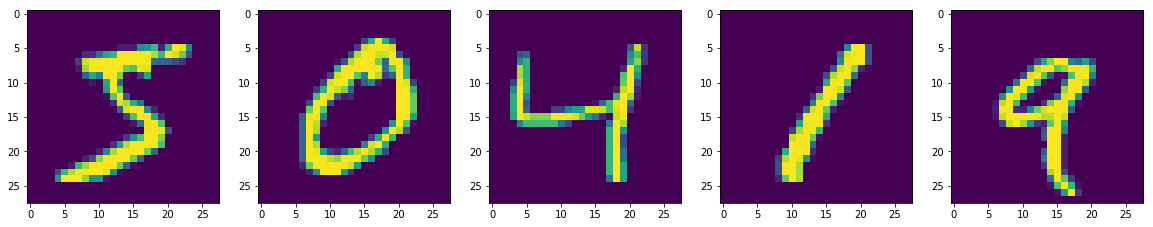

In [8]:
_, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(X_train[i])

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [11]:
if os.path.exists('models/autoenc_for_mnist.h5'):
    autoencoder = keras.models.load_model('models/autoenc_for_mnist.h5')
else:
    input_img = Input(shape=(X_train.shape[1],))
    encod = Dense(30, activation='relu')(input_img)
    decod_out = Dense(X_train.shape[1], activation='sigmoid')(encod)
    
    autoencoder = Model(input_img, decod_out)
    autoencoder.compile(loss="mean_squared_error", optimizer='Adamax')
    autoencoder.fit(X_train, X_train, epochs=20)

X_train_processed = autoencoder.predict(X_train)
X_test_processed = autoencoder.predict(X_test)

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

In [12]:
accuracy_scores = {}

In [13]:
knn = KNeighborsClassifier()
svc = SVC()
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()

In [14]:
%%time
knn.fit(X_train_processed, y_train)
accuracy_scores.update({'knn_accuracy': accuracy_score(y_test, knn.predict(X_test_processed))})
print('Done')

Done
CPU times: user 10min 29s, sys: 1.35 s, total: 10min 31s
Wall time: 10min 31s


In [15]:
%%time
svc.fit(X_train_processed, y_train)
accuracy_scores.update({'svc_accuracy': accuracy_score(y_test, svc.predict(X_test_processed))})
print('Done')

Done
CPU times: user 31min 4s, sys: 6.72 s, total: 31min 11s
Wall time: 31min 11s


In [16]:
%%time
rf.fit(X_train_processed, y_train)
accuracy_scores.update({'rf_accuracy': accuracy_score(y_test, rf.predict(X_test_processed))})
print('Done')

Done
CPU times: user 3.96 s, sys: 64 ms, total: 4.02 s
Wall time: 4.67 s


In [17]:
%%time
gbc.fit(X_train_processed, y_train)
accuracy_scores.update({'xgbc_accuracy': accuracy_score(y_test, gbc.predict(X_test_processed))})
print('Done')

Done
CPU times: user 28min 36s, sys: 7.46 s, total: 28min 43s
Wall time: 28min 44s


In [18]:
accuracy_scores

{'knn_accuracy': 0.81030000000000002,
 'rf_accuracy': 0.80910000000000004,
 'svc_accuracy': 0.79420000000000002,
 'xgbc_accuracy': 0.82099999999999995}

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [92]:
(X_train, y_trainin), (X_test, y_test) = cifar10.load_data()

In [93]:
X_train = reshape_samples(rgb_scaler(X_train))

/home/kirill/Machine_Learning/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [94]:
input_img = Input(shape=(X_train.shape[1],))
encod = Dense(30, activation='relu')(input_img)
decod_out = Dense(X_train.shape[1], activation='sigmoid')(encod)
    
encod_cifar = Model(input_img, encod)
autoenc_cifar = Model(input_img, decod_out)
autoenc_cifar.compile(loss="mean_squared_error", optimizer='Adamax')
autoenc_cifar.fit(X_train, X_train, epochs=10)

Epoch 1/10
50000/50000 [==============================] - 20s 396us/step - loss: 0.0328
Epoch 2/10
50000/50000 [==============================] - 21s 425us/step - loss: 0.0302
Epoch 3/10
50000/50000 [==============================] - 26s 522us/step - loss: 0.0294
Epoch 4/10
50000/50000 [==============================] - 26s 514us/step - loss: 0.0289
Epoch 5/10
50000/50000 [==============================] - 23s 455us/step - loss: 0.0285
Epoch 6/10
50000/50000 [==============================] - 21s 418us/step - loss: 0.0283
Epoch 7/10
50000/50000 [==============================] - 21s 425us/step - loss: 0.0282
Epoch 8/10
50000/50000 [==============================] - 21s 427us/step - loss: 0.0281
Epoch 9/10
50000/50000 [==============================] - 22s 431us/step - loss: 0.0281
Epoch 10/10
50000/50000 [==============================] - 21s 422us/step - loss: 0.0281
